<h1> Training Notebook for Model 2 </h1>

In [22]:
# Loading libraries - cleaned up and optimized order
import os
import numpy as np
import glob
import json

# Data processing and visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Audio processing
import librosa
import librosa.display

# Deep learning
import keras
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

print("✅ All libraries imported successfully!")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Librosa version: {librosa.__version__}")

✅ All libraries imported successfully!
Keras version: 3.11.3
NumPy version: 2.2.6
Librosa version: 0.11.0


In [32]:
# please set this variable to where you cloned the git repo "MLAudioClassifier"

filepath = "/Users/Gilby/Projects/MLAudioClassifier"
os.chdir(filepath)

# make sure you have extracted the Training Data before you proceed with the rest of the notebook
# with something like "unzip TrainingData.zip"

<h1> Load in the training data and calculate the spectrogram for each file </h1>

In [33]:
# Check actual spectrogram dimensions before preprocessing
print("Checking spectrogram dimensions...")
sample_file = glob.glob("TrainingData/AudioSamples/*/*.wav")[0]
waveform, samplerate = librosa.load(sample_file, sr=22050, mono=True)
waveform = librosa.util.fix_length(waveform, size=32600)
spec = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_fft=512, hop_length=256)
normalized_spec = librosa.util.normalize(spec)
print(f"Original spectrogram shape: {normalized_spec.shape}")

# If your spectrograms are not 128x128, we need to resize them
import cv2

ALLOWED_INSTRUMENTS = ["Crash", "Hihat", "Kick", "Ride", "Snare", "Tom"]  # target 6 classes
print("Target instrument classes:", ALLOWED_INSTRUMENTS)

# Build mapping only for allowed instruments present in dataset
os.chdir("TrainingData/AudioSamples")
available_folders_all = sorted([f for f in glob.glob("*") if os.path.isdir(f)])
print(f"Found {len(available_folders_all)} total folders: {available_folders_all}")

# Filter to allowed instruments actually present
folder_names = [f for f in available_folders_all if f in ALLOWED_INSTRUMENTS]
missing = [f for f in ALLOWED_INSTRUMENTS if f not in folder_names]
if missing:
    print("⚠️ Missing expected instrument folders:", missing)
print(f"Using {len(folder_names)} instrument folders for training: {folder_names}")

if len(folder_names) == 0:
    raise RuntimeError("No allowed instrument folders found. Please ensure training data is organized under 'TrainingData/AudioSamples/<InstrumentName>'.")

# Create deterministic class index mapping
class_index = {inst: idx for idx, inst in enumerate(sorted(folder_names))}
print("Class index mapping:", class_index)

x_train = []
t_train = []

def resize_spectrogram(spec, target_size=(128, 128)):
    """Resize spectrogram to target dimensions"""
    spec_norm = ((spec - spec.min()) / (spec.max() - spec.min() + 1e-9) * 255).astype(np.uint8)
    resized = cv2.resize(spec_norm, target_size)
    return resized.astype(np.float32) / 255.0

file_count = 0
for instrument in folder_names:
    os.chdir(instrument)
    file_names = glob.glob("*.wav")
    if not file_names:
        print(f"⚠️  No wav files in {instrument}")
    for wav in file_names:
        try:
            waveform, samplerate = librosa.load(wav, sr=22050, mono=True)
            waveform = librosa.util.fix_length(waveform, size=32600)
            spec = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_fft=512, hop_length=256)
            normalized_spec = librosa.util.normalize(spec)
            if normalized_spec.shape != (128, 128):
                normalized_spec = resize_spectrogram(normalized_spec, target_size=(128, 128))
            x_train.append(normalized_spec)
            t_train.append(class_index[instrument])
            file_count += 1
            if file_count % 200 == 0:
                print(f"Processed {file_count} files...")
        except Exception as e:
            print(f"Error processing {instrument}/{wav}: {e}")
    os.chdir("..")

x_train = np.array(x_train, dtype=np.float32)
# Add channel dimension
x_train = x_train[..., np.newaxis]

os.chdir(filepath)

print(f"Final x_train shape: {x_train.shape}")
print(f"Total samples: {len(t_train)}")
print(f"Label distribution: {np.bincount(t_train)}")

# Consistency checks
def check_data_consistency():
    print("=== Data Consistency Check ===")
    print(f"x_train shape: {x_train.shape}")
    print(f"t_train length: {len(t_train)}")
    unique_classes = sorted(set(t_train))
    print(f"Unique class indices: {unique_classes}")
    print(f"Class counts: {np.bincount(t_train)}")
    return len(unique_classes)

num_classes = check_data_consistency()
print(f"✅ Using {num_classes} classes.")
if num_classes != 6:
    print("⚠️  Note: Number of classes differs from expected 6. Model will adapt dynamically.")

Checking spectrogram dimensions...
Original spectrogram shape: (128, 128)
Target instrument classes: ['Crash', 'Hihat', 'Kick', 'Ride', 'Snare', 'Tom']
Found 34 total folders: ['Agogo', 'Bell', 'Bongo', 'Cabasa', 'China', 'Clap', 'Clave', 'Conga', 'Cowbell', 'Crash', 'Cuica', 'FX', 'Guiro', 'Hihat', 'Kick', 'Maracas', 'Metal', 'Noise', 'Perc', 'Reverse', 'Ride', 'Rim', 'Shaker', 'Snare', 'Splash', 'Tambourine', 'Timbale', 'Timpani', 'Tom', 'Triangle', 'Vibraslap', 'Vox', 'Whistle', 'Woodblock']
Using 6 instrument folders for training: ['Crash', 'Hihat', 'Kick', 'Ride', 'Snare', 'Tom']
Class index mapping: {'Crash': 0, 'Hihat': 1, 'Kick': 2, 'Ride': 3, 'Snare': 4, 'Tom': 5}
Processed 200 files...
Processed 200 files...
Processed 400 files...
Processed 400 files...
Processed 600 files...
Processed 600 files...
Processed 800 files...
Processed 800 files...
Processed 1000 files...
Processed 1000 files...
Processed 1200 files...
Processed 1200 files...
Processed 1400 files...
Processed 1400

<h1> Let's plot a few of the spectrograms so we know what each class looks like </h1>

Found 34 instrument categories with samples:
  Kick: Br Kick 2 [V1].wav
  Rim: Rim 2.wav
  Splash: Splash6 U3.wav
  Tom: 05 Ana 2Hi.wav
  Shaker: Track  2 Shaker.wav
  Bongo: Hi Bongo Wet.wav
  Conga: CH_mt_m  1-L.wav
  Maracas: 50 Maracas1.wav
  Metal: Metal Noise.wav
  Hihat: HiHat_120.wav
  Snare: Snare (12).wav
  Perc: Perc2 128.wav
  FX: Blip Scratch.wav
  Ride: Ride 1.wav
  Agogo: Agogo Bell H [V1].wav
  Triangle: 68 G#5 - Triangle Mute3.wav
  Whistle: Apito Hi Short.wav
  Crash: Crash 3 [V2].wav
  Reverse: Rev S.wav
  China: China Cymbal 3 [V2].wav
  Tambourine: Tambourine 7.wav
  Vox: BassDrum-Pop Vox.wav
  Noise: 25 C#2 - Cutting Noise 2.wav
  Clap: Clap 2.wav
  Woodblock: Wood Block Hi.wav
  Clave: Clave Lo.wav
  Bell: Bell_44d.wav
  Cowbell: ChaCha Cowbell 1 [V1].wav
  Cabasa: Real Cabasa 2.wav
  Vibraslap: Vibraslap2.wav
  Guiro: Guiro Long.wav
  Timpani: Timpani.wav
  Cuica: Cuica 04.wav
  Timbale: p Timbale.wav

Processing Kick: Br Kick 2 [V1].wav

Processing Rim: Rim 2.w

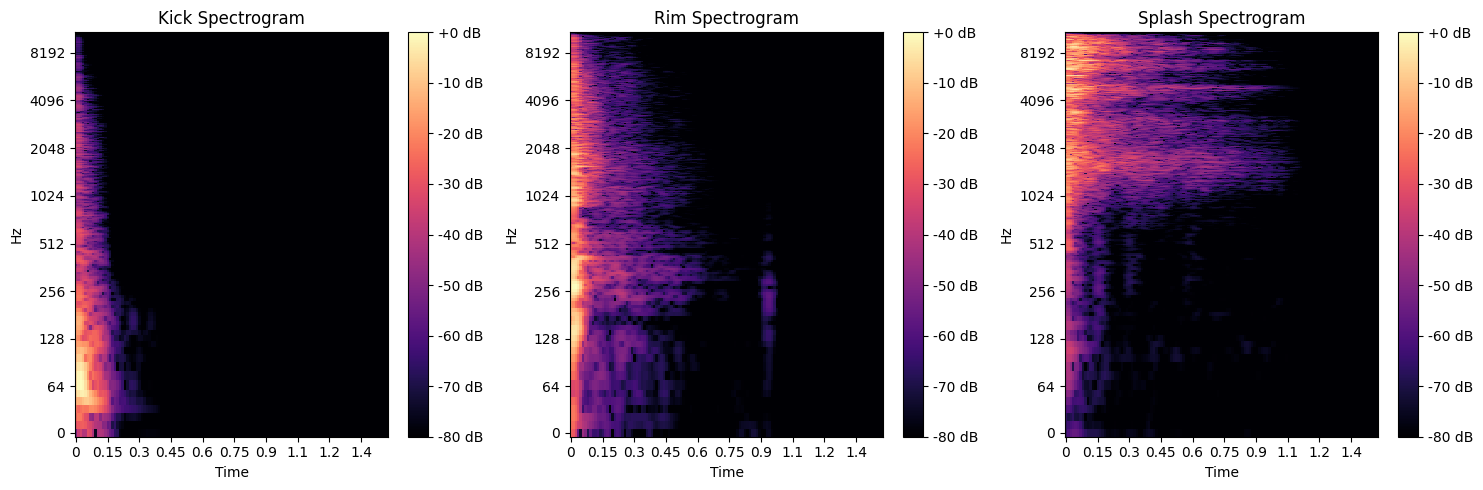


Also available: Tom, Shaker, Bongo, Conga, Maracas, Metal, Hihat, Snare, Perc, FX, Ride, Agogo, Triangle, Whistle, Crash, Reverse, China, Tambourine, Vox, Noise, Clap, Woodblock, Clave, Bell, Cowbell, Cabasa, Vibraslap, Guiro, Timpani, Cuica, Timbale
You can modify this cell to plot spectrograms for other instruments.


In [34]:
# Let's plot spectrograms from actual files in your training data
import os
import glob
import matplotlib.pyplot as plt
import librosa
import numpy as np

# Function to find the first available audio file in each category
def find_sample_file(instrument_folder):
    """Find the first .wav file in the given instrument folder"""
    folder_path = f"TrainingData/AudioSamples/{instrument_folder}"
    if os.path.exists(folder_path):
        wav_files = glob.glob(os.path.join(folder_path, "*.wav"))
        if wav_files:
            return wav_files[0]  # Return first available file
    return None

# Check what instrument folders we have
instruments_to_plot = []
available_folders = glob.glob("TrainingData/AudioSamples/*")
for folder in available_folders:
    if os.path.isdir(folder):
        folder_name = os.path.basename(folder)
        sample_file = find_sample_file(folder_name)
        if sample_file:
            instruments_to_plot.append((folder_name, sample_file))

print(f"Found {len(instruments_to_plot)} instrument categories with samples:")
for instrument, file_path in instruments_to_plot:
    print(f"  {instrument}: {os.path.basename(file_path)}")

# Plot spectrograms for the first 3 available instruments
plt.figure(figsize=(15, 5))

for idx, (instrument, filename) in enumerate(instruments_to_plot[:3]):
    try:
        print(f"\nProcessing {instrument}: {os.path.basename(filename)}")
        
        # Load and process audio
        y, sr = librosa.load(filename, sr=22050, mono=True)
        y = librosa.util.fix_length(y, size=32600)
        y_harm, y_perc = librosa.effects.hpss(y)
        
        # Create spectrogram
        hop_length = 256
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_perc, hop_length=hop_length)),
                                    ref=np.max)
        
        # Plot
        plt.subplot(1, 3, idx + 1)
        librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                                x_axis='time')
        plt.title(f'{instrument} Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        
    except Exception as e:
        print(f"Error processing {instrument}: {str(e)}")

plt.tight_layout()
plt.show()

# Also plot all available instruments if we have more than 3
if len(instruments_to_plot) > 3:
    print(f"\nAlso available: {', '.join([inst for inst, _ in instruments_to_plot[3:]])}")
    print("You can modify this cell to plot spectrograms for other instruments.")

<h1> Building the Autoencoder </h1>

In [35]:
input_img = keras.Input(shape=(128, 128, 1))

###
# Define the encoder of an autoencoder. 
# It should take in the 'input_img' variable, and output the encoded input, with a chosen number of dimensions
# Define multiple sets of {convolutional, maxpooling} layers.
# YOUR CODE BELOW

#encoded
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
#
###


###
# Define the decoder of our autoencoder. 
# It should take in the 'encoded' variable, and output the decoded input, here the same dimensions as the input (128, 128, 1).
# Define multiple sets of {convolutional, upsampling} layers.
# YOUR CODE BELOW
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

#
###

autoencoder = keras.Model(input_img, decoded)

# Feel free to play around with the learning rate.
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

<h1> Training the Autoencoder </h1>

In [36]:
print(x_train.shape)
autoencoder.fit(x_train, x_train,
               epochs=10,
               batch_size=128,
               shuffle=True,
               callbacks=[TensorBoard(log_dir="logs")])

(7031, 128, 128, 1)
Epoch 1/10
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - loss: 0.0052
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - loss: 0.0052
Epoch 2/10
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - loss: 0.0038
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - loss: 0.0038
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - loss: 0.0032
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - loss: 0.0032
Epoch 4/10
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - loss: 0.0030
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - loss: 0.0030
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - loss: 0.0029
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - loss: 0.0029
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - loss: 0.0028
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - loss: 0.0028
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - loss: 0.0027
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - loss: 0.0027
Epoch 8/10
55/55 

<h1> Encode all the spectrograms into the latent variable space </h1>

<p> Separate the encoder part of that model and save that to a file we can use later. </p>

In [37]:
encoder=keras.Model(input_img, encoded)
encoder_output = encoder.predict(x_train)
encoder.save("models/encoder.keras")


220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


<h1> Visualize the different classes spread across part of the latent space </h1>

encoder_output shape: (7031, 16, 16, 8)
Total elements in encoder_output: 14399488
Number of samples (x_train): 7031
Calculated reshape: (7031, 2048)
(7031, 2048)


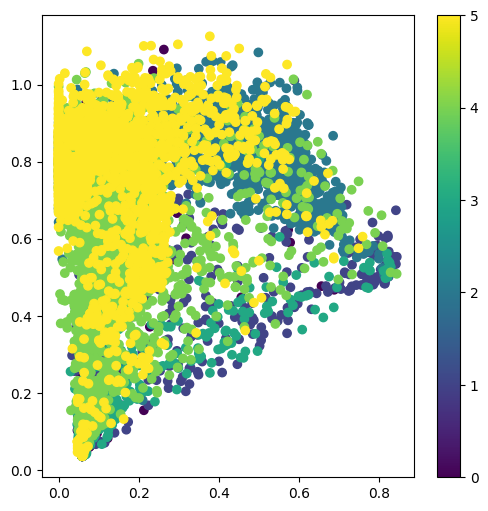

In [38]:
# This cell is already correct - it dynamically calculates the reshape dimensions
print(f"encoder_output shape: {encoder_output.shape}")
print(f"Total elements in encoder_output: {encoder_output.size}")
print(f"Number of samples (x_train): {len(x_train)}")

# Calculate the correct reshape dimensions
num_samples = encoder_output.shape[0]
feature_dims = encoder_output.shape[1] * encoder_output.shape[2] * encoder_output.shape[3]

print(f"Calculated reshape: ({num_samples}, {feature_dims})")

# Use the actual dimensions instead of hardcoded values
latents = np.reshape(encoder_output, [num_samples, feature_dims])
print(latents.shape)
plt.figure(figsize=(6, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=t_train)
plt.colorbar()
plt.show()

<h1> Building the CNN </h1>

In [39]:
t = np.array(t_train)

# Ensure labels are contiguous 0..num_classes-1
unique_labels = np.unique(t)
if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
    print("⚠️  Non-contiguous label indices detected. Remapping.")
    remap = {old:i for i, old in enumerate(unique_labels)}
    t = np.array([remap[v] for v in t])
    unique_labels = np.unique(t)
print("Label set after normalization:", unique_labels)
num_classes = len(unique_labels)
print(f"Inferred num_classes: {num_classes}")

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(encoder_output, t, test_size=0.2, stratify=t, random_state=42)

# Neural network
model = keras.Sequential([
        keras.layers.Flatten(input_shape=(encoder_output.shape[1], encoder_output.shape[2], encoder_output.shape[3])),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation='softmax')
])
    
optimiser = keras.optimizers.Adam(learning_rate=0.0003)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print(f"Model output units: {model.layers[-1].units} (should match num_classes={num_classes})")
model.summary()

Label set after normalization: [0 1 2 3 4 5]
Inferred num_classes: 6


/Users/Gilby/Projects/MLAudioClassifier/.venv/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model output units: 6 (should match num_classes=6)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,214,086 (4.63 MB)

 Trainable params: 1,214,086 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

<h1> Training the CNN on the features from the CAE </h1>

In [40]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=60,
    callbacks=callbacks,
    verbose=1
)

# Safe save paths
models_dir = os.path.join(filepath, 'models')
results_dir = os.path.join(filepath, 'results')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

model_path = os.path.join(models_dir, 'model2.keras')
model.save(model_path)
print(f"✅ Model saved to {model_path}")

Epoch 1/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6629 - loss: 0.9151 - val_accuracy: 0.7854 - val_loss: 0.5859 - learning_rate: 3.0000e-04
Epoch 2/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6629 - loss: 0.9151 - val_accuracy: 0.7854 - val_loss: 0.5859 - learning_rate: 3.0000e-04
Epoch 2/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7687 - loss: 0.6562 - val_accuracy: 0.8060 - val_loss: 0.5227 - learning_rate: 3.0000e-04
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7687 - loss: 0.6562 - val_accuracy: 0.8060 - val_loss: 0.5227 - learning_rate: 3.0000e-04
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7943 - loss: 0.5957 - val_accuracy: 0.8159 - val_loss: 0.4900 - learning_rate: 3.0000e-04
Epoch 4/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7943 - loss: 0.5957 - val_accuracy: 0.8159 - val_loss: 0.4900 - learning_rate: 3.0000e-04
Epoch 4/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


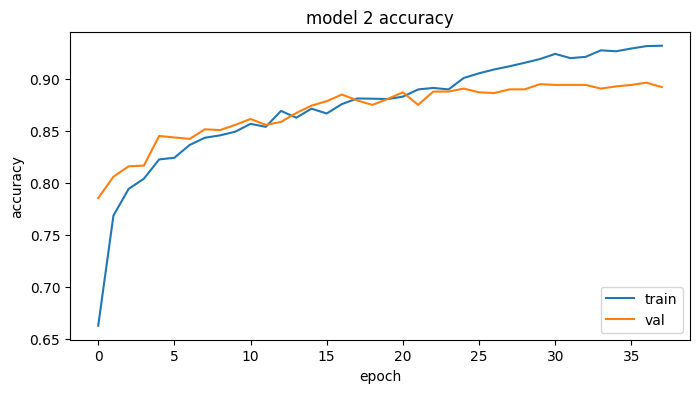

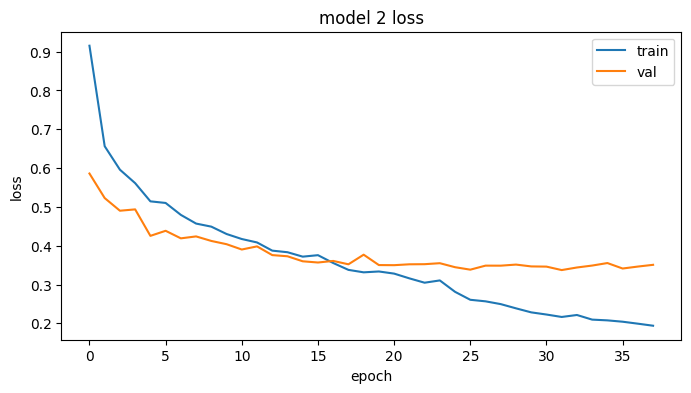

📄 History saved to /Users/Gilby/Projects/MLAudioClassifier/models/model2_history.json


In [41]:
import json
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig(os.path.join(results_dir,'model2_accuracy.png'), dpi=120, bbox_inches='tight')
plt.show()
# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig(os.path.join(results_dir,'model2_loss.png'), dpi=120, bbox_inches='tight')
plt.show()

# Save training history json
history_path = os.path.join(models_dir, 'model2_history.json')
with open(history_path, 'w') as f:
    json.dump({k:[float(vv) for vv in vals] for k, vals in history.history.items()}, f, indent=2)
print(f"📄 History saved to {history_path}")